<a href="https://colab.research.google.com/github/1PD-IS-NO-1/mlproject/blob/main/finance_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Financial RAG on PDF's  P&L table data**

In [ ]:
! pip install -q "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib
!sudo apt-get install -q libleptonica-dev tesseract-ocr libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn
!pip install -q unstructured-pytesseract
!pip install -q tesseract-ocr
from unstructured.partition.pdf import partition_pdf
!sudo apt-get install poppler-utils
!sudo apt-get install tesseract-ocr
import nltk
nltk.download('punkt_tab')
import nltk
nltk.download('averaged_perceptron_tagger_eng')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.6/514.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
mkdir data extracted_data

In [ ]:
raw_pdf_elements=partition_pdf(
    filename="/content/data/SampleFinancialStatement.pdf",                  # mandatory
    strategy="hi_res",                                 # mandatory to use ``hi_res`` strategy
    extract_images_in_pdf=True,                       # mandatory to set as ``True``
    extract_image_block_types=["Image", "Table"],          # optional
    extract_image_block_to_payload=False,                  # optional
    extract_image_block_output_dir="extracted_data",  # optional - only works when ``extract_image_block_to_payload=False``
    )

Header=[]
Footer=[]
Title=[]
NarrativeText=[]
texts=[]
ListItem=[]
for element in raw_pdf_elements:
  if "unstructured.documents.elements.Header" in str(type(element)):
            Header.append(str(element))
  elif "unstructured.documents.elements.Footer" in str(type(element)):
            Footer.append(str(element))
  elif "unstructured.documents.elements.Title" in str(type(element)):
            Title.append(str(element))
  elif "unstructured.documents.elements.NarrativeText" in str(type(element)):
            NarrativeText.append(str(element))
  elif "unstructured.documents.elements.Text" in str(type(element)):
            texts.append(str(element))
  elif "unstructured.documents.elements.ListItem" in str(type(element)):
            ListItem.append(str(element))


img=[]
for element in raw_pdf_elements:
  if "unstructured.documents.elements.Image" in str(type(element)):
            img.append(str(element))


tab=[]
for element in raw_pdf_elements:
  if "unstructured.documents.elements.Table" in str(type(element)):
            tab.append(str(element))


texts=[]
for element in raw_pdf_elements:
  if "unstructured.documents.elements.NarrativeText" in str(type(element)):
            texts.append(str(element))

## **Table**

In [ ]:
!pip install -q langchain_core chromadb langchain langchain_community sentence_transformers
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import os
class TableEmbedder:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.embedding_model = SentenceTransformer(model_name)

    def convert_table_to_text(self, table):
        """Convert table to text representation"""
        return str(table)

    def embed_table(self, table):
        """Embed entire table as text"""
        table_text = self.convert_table_to_text(table)
        return self.embedding_model.encode(table_text)

    def embed_tables(self, tables):
        """Embed multiple tables"""
        return [self.embed_table(table) for table in tables]

    def retrieve_top_k_tables(self, query, tables, k=5):
        """Retrieve top-k most relevant tables based on query embedding"""
        # Embed query
        query_embedding = self.embedding_model.encode(query)

        # Embed tables
        table_embeddings = self.embed_tables(tables)

        # Calculate cosine similarities
        similarities = [
            cosine_similarity([query_embedding], [table_emb])[0][0]
            for table_emb in table_embeddings
        ]

        # Get top-k indices
        top_k_indices = sorted(
            range(len(similarities)),
            key=lambda i: similarities[i],
            reverse=True
        )[:k]

        return [tables[i] for i in top_k_indices]

def table_query_processor(query, tables, llm_model='gemini'):
    """Process query across tables using semantic retrieval"""
    # Initialize table embedder
    table_embedder = TableEmbedder()

    # Retrieve most relevant tables
    relevant_tables = table_embedder.retrieve_top_k_tables(query, tables)

    # Use Gemini to generate answer based on retrieved tables
    import google.generativeai as genai

    # Configure Gemini
    genai.configure(api_key='Paste_gemin_api_key_here')
    model = genai.GenerativeModel('gemini-1.5-flash')

    # Combine tables into context
    context = "\n\n".join(str(table) for table in relevant_tables)

    # Generate response
    full_prompt = f"""Context: {context}

    Query: {query}

    Based on the provided tables, answer the query precisely and comprehensively."""

    response = model.generate_content(full_prompt)

    return {
        'answer': response.text,
        'retrieved_tables': relevant_tables
    }

# Usage example


The gross profit for the three months ended March 31, 2024 (Q3 2024) is ₹11,175 crore.


5


Particulars Note No. Three months ended March 31, 2024 2023 Revenue from operations 2.16 37,923 37,441 Cost of Sales 26,748 26,011 Gross profit 11,175 11,430 Operating expenses Selling and marketing expenses 1,735 1,659 General and administration expenses 1,819 1,894 Total operating expenses 3,554 3,553 Operating profit 7,621 7,877 Other income, net 2.17 2,729 671 Finance cost 110 82 Profit before tax 10,240 8,466 Tax expense: Current tax 2.15 1,173 2,260 Deferred tax 2.15 1,092 72 Profit for the period 7,975 6,134 Other comprehensive income Items that will not be reclassified subsequently to profit or loss Remeasurement of the net defined benefit liability/asset, net 26 25 Equity instruments through other comprehensive income, net (12) (15) 14 10 Items that will be reclassified subsequently to profit or loss Fair value changes on derivatives designated as cash flow hedge, net 28 36 Exchange differences on translation of foreign operations (231) 61 Fair value changes on investments, net 37 42 (166) 139 Total other comprehensive income / (loss), net of tax (152) 149 Total comprehensive income for the period 7,823 6,283 Profit attributable to: Owners of the Company 7,969 6,128 Non-controlling interests 6 6 7,975 6,134 Total comprehensive income attributable to: Owners of the Company 7,821 6,276 Non-controlling interests 2 7 7,823 6,283 Year ended March 31, 2024 153,670 107,413 46,257 6,973 7,537 14,510 31,747 4,711 470 35,988 8,390 26,248 120 139 226 381 520 26,768 26,233 15 26,248 26,754 14 26,768

Condensed Consolidated Statement of Profit and Loss for the Note No. Three months ended March 31, Year ended March 31, 2024 2023 2024 Revenue from operations 2.16 Other income, net 2.17 Total income Employee benefit expenses 2.18 Cost of technical sub-contractors Travel expenses Cost of software packages and others 2.18 Communication expenses Consultancy and professional charges Depreciation and amortization expenses Other expenses 2.18 Total expenses Profit before tax Current tax 2.15 Deferred tax 2.15 1,092 72 1,350 (73) Profit for the period Other comprehensive income Items that will not be reclassified subsequently to profit or loss Remeasurement of the net defined benefit liability/asset, net Equity instruments through other comprehensive income, net (12) (15) 19 (7) Items that will be reclassified subsequently to profit or loss Fair value changes on derivatives designated as cash flow hedge, net 28 36 11 (7) Exchange differences on translation of foreign operations Fair value changes on investments, net 37 42 144 (256) Total other comprehensive income /(loss), net of tax Total comprehensive income for the period Profit attributable to: Owners of the Company Non-controlling interests Total comprehensive income attributable to: Owners of the Company Non-controlling interests Earnings per equity share Equity shares of par value ₹5/- each Basic (in ₹ per share) Diluted (in ₹ per share) Weighted average equity shares used in computing earnings per equity share Basic (in shares) 2.20 Diluted (in shares) 2.20

Financial Retail (2) Communic Energy, Manufacturing Hi-Tech Life All other Services (1)* ation (3) Utilities, Sciences (4) segments (5) Particulars Resources and Services Revenue from operations 42,158 22,504 17,991 20,035 22,298 12,411 11,515 4,758 43,763 21,204 18,086 18,539 19,035 11,867 10,085 4,188 Identifiable operating expenses 24,782 11,704 11,071 10,838 14,596 7,232 6,716 2,938 24,990 10,892 11,101 9,923 12,493 6,959 5,834 2,801 Allocated expenses 8,052 3,918 3,232 3,674 3,505 2,026 1,901 1,060 7,930 3,916 3,226 3,461 3,429 1,949 1,685 1,048 Segment operating income 9,324 6,882 3,688 5,523 4,197 3,153 2,898 760 10,843 6,396 3,759 5,155 3,113 2,959 2,566 339 Unallocable expenses Other income, net (Refer to Note 2.17) Finance cost Profit before tax Income tax expense Net Profit Depreciation and amortization expense Non-cash expenses other than depreciation and amortization Total 146,767 84,993 26,644 35,130 4,225 2,701 33,322 9,214 24,108 4,225 —

Financial Retail (2) Communic Energy, Manufacturing Hi-Tech Life All other Services (1)* ation (3) Utilities, Sciences (4) segments (5) Particulars Resources and Services Revenue from operations 10,010 5,429 4,666 5,068 5,589 3,316 2,762 1,083 10,818 5,537 4,411 4,825 5,078 2,989 2,681 1,102 Identifiable operating expenses 6,042 2,591 3,033 2,717 3,656 1,995 1,639 652 6,161 2,869 2,613 2,614 3,248 1,734 1,514 701 Allocated expenses 2,027 974 823 920 852 518 491 209 2,057 1,034 840 909 928 505 462 254 Segment operating income 1,941 1,864 810 1,431 1,081 803 632 222 2,600 1,634 958 1,302 902 750 705 147 Unallocable expenses Other income, net (Refer to Note 2.17) Finance cost Profit before tax Income tax expense Net Profit Depreciation and amortization Non-cash expenses other than depreciation and amortization (In ₹ crore) Total 37,441 21,454 6,989 8,998 1,121 671 82 8,466 2,332 6,134 1,121

Particulars Note No. Year ended March 31, 2024 2023 Cash flow from operating activities Profit for the period 26,248 24,108 Adjustments to reconcile net profit to net cash provided by operating activities: Income tax expense 2.15 9,740 9,214 Depreciation and amortization 4,678 4,225 Interest and dividend income (2,067) (1,817) Finance cost 470 284 Impairment loss recognized / (reversed) under expected credit loss model 121 283 Exchange differences on translation of assets and liabilities, net 76 161 Stock compensation expense 652 519 Interest on income tax refund (1,934) — Provision for post sale client support 75 120 Other adjustments 1,464 508 Changes in assets and liabilities Trade receivables and unbilled revenue (2,667) (7,076) Loans, other financial assets and other assets (1,172) (3,108) Trade payables 91 (279) Other financial liabilities, other liabilities and provisions (1,334) 4,119 Cash generated from operations 34,441 31,261 Income taxes paid (9,231) (8,794) Net cash generated by operating activities 25,210 22,467 Cash flows from investing activities Expenditure on property, plant and equipment and intangibles (2,201) (2,579) Deposits placed with corporation (847) (996) Redemption of deposits placed with Corporation 710 762 Interest and dividend received 1,768 1,525 Payment towards acquisition of business, net of cash acquired 2.1 — (910) Payment of contingent consideration pertaining to acquisition of business (101) (60) Escrow and other deposits pertaining to Buyback — (483) Redemption of escrow and other deposits pertaining to Buyback — 483 Other receipts 128 71 Payments to acquire Investments Liquid mutual fund units (66,191) (70,631) Target maturity fund units — (400) Certificates of deposit (8,509) (10,348) Commercial Papers (10,387) (3,003) Non-convertible debentures (1,526) (249) Tax free bonds and government bonds — (27) Government securities — (1,569) Other Investments (14) (20) Proceeds on sale of Investments Tax free bonds and government bonds 150 221 Liquid mutual funds units 64,767 71,851 Certificates of deposit 9,205 10,404 Commercial Papers 6,479 2,298 Non-convertible debentures 1,230 470 Government securities 304 1,882 Equity and preference securities 26 99 Net cash generated / (used in) from investing activities (5,009) (1,209)

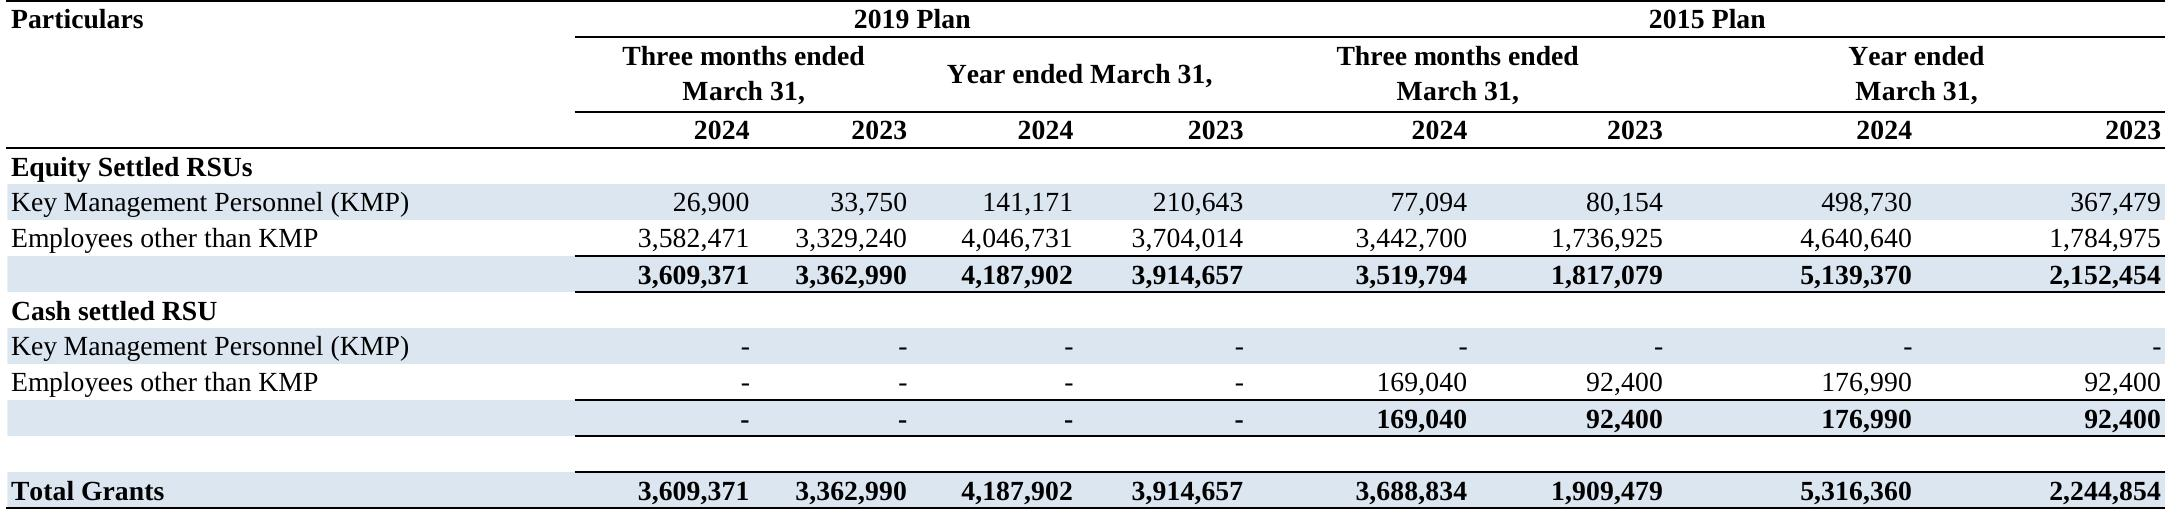

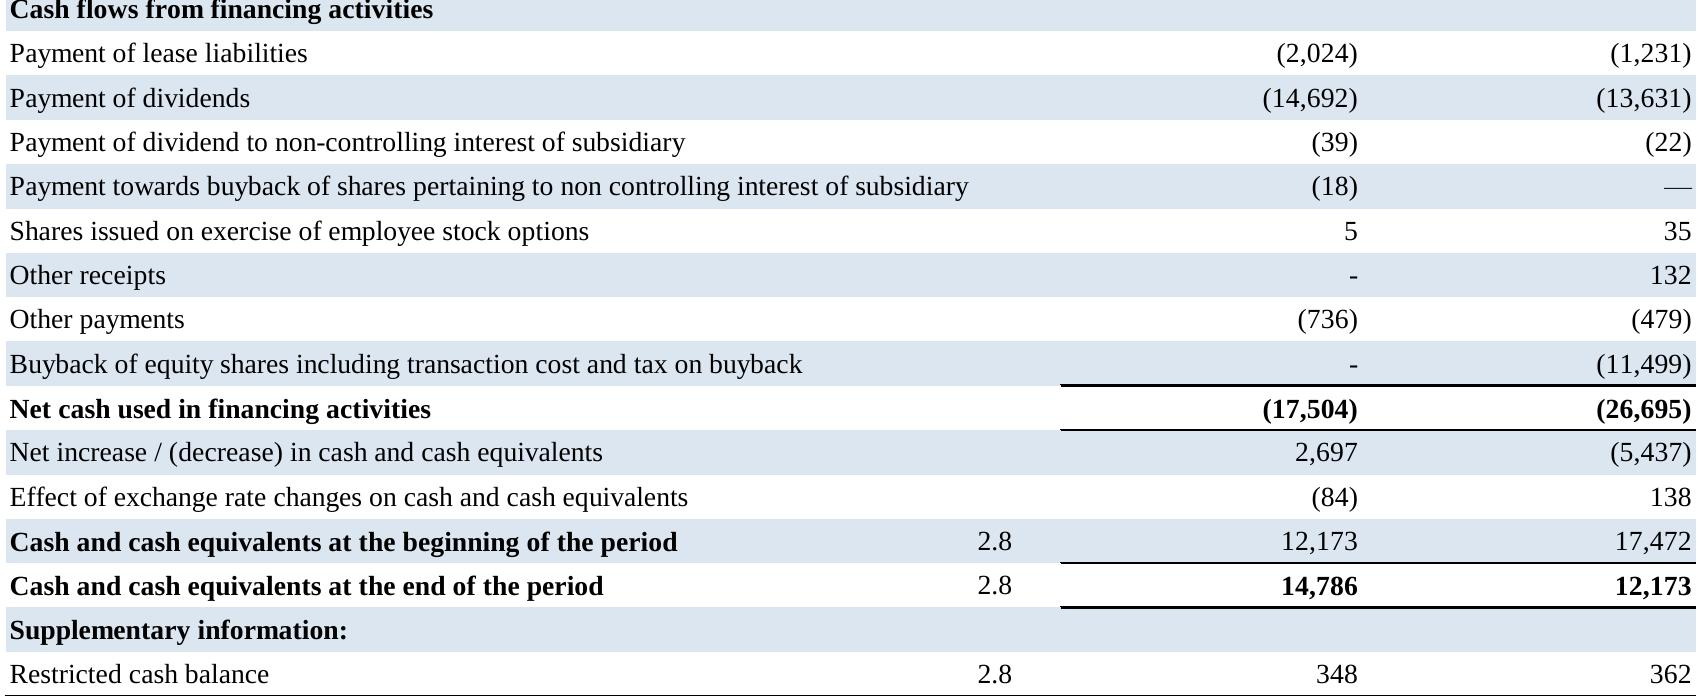

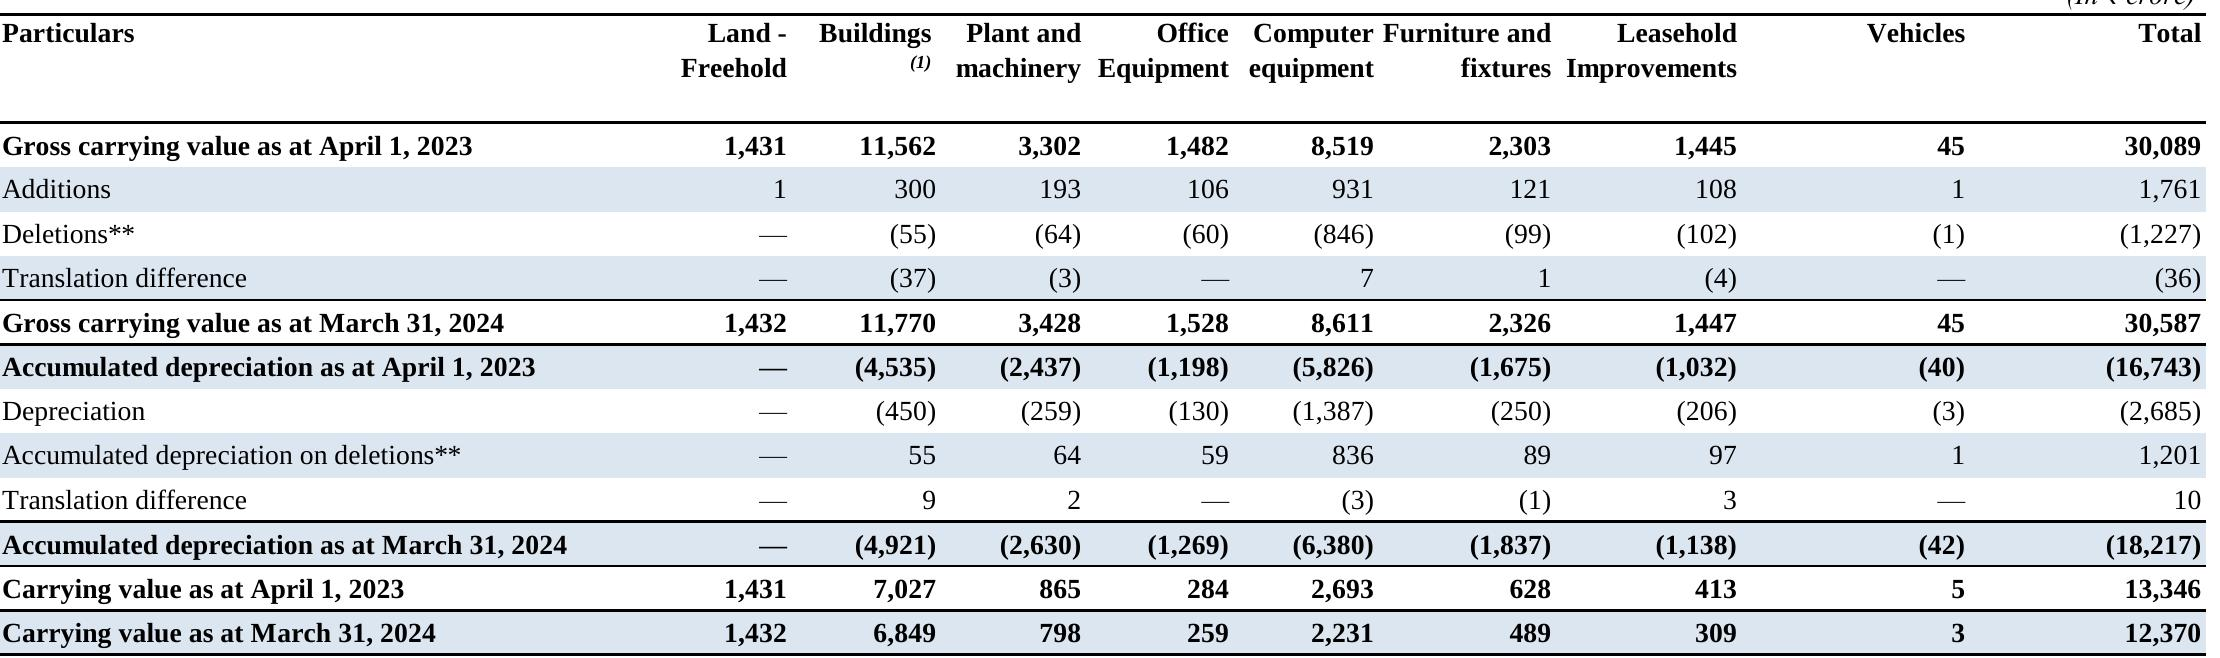

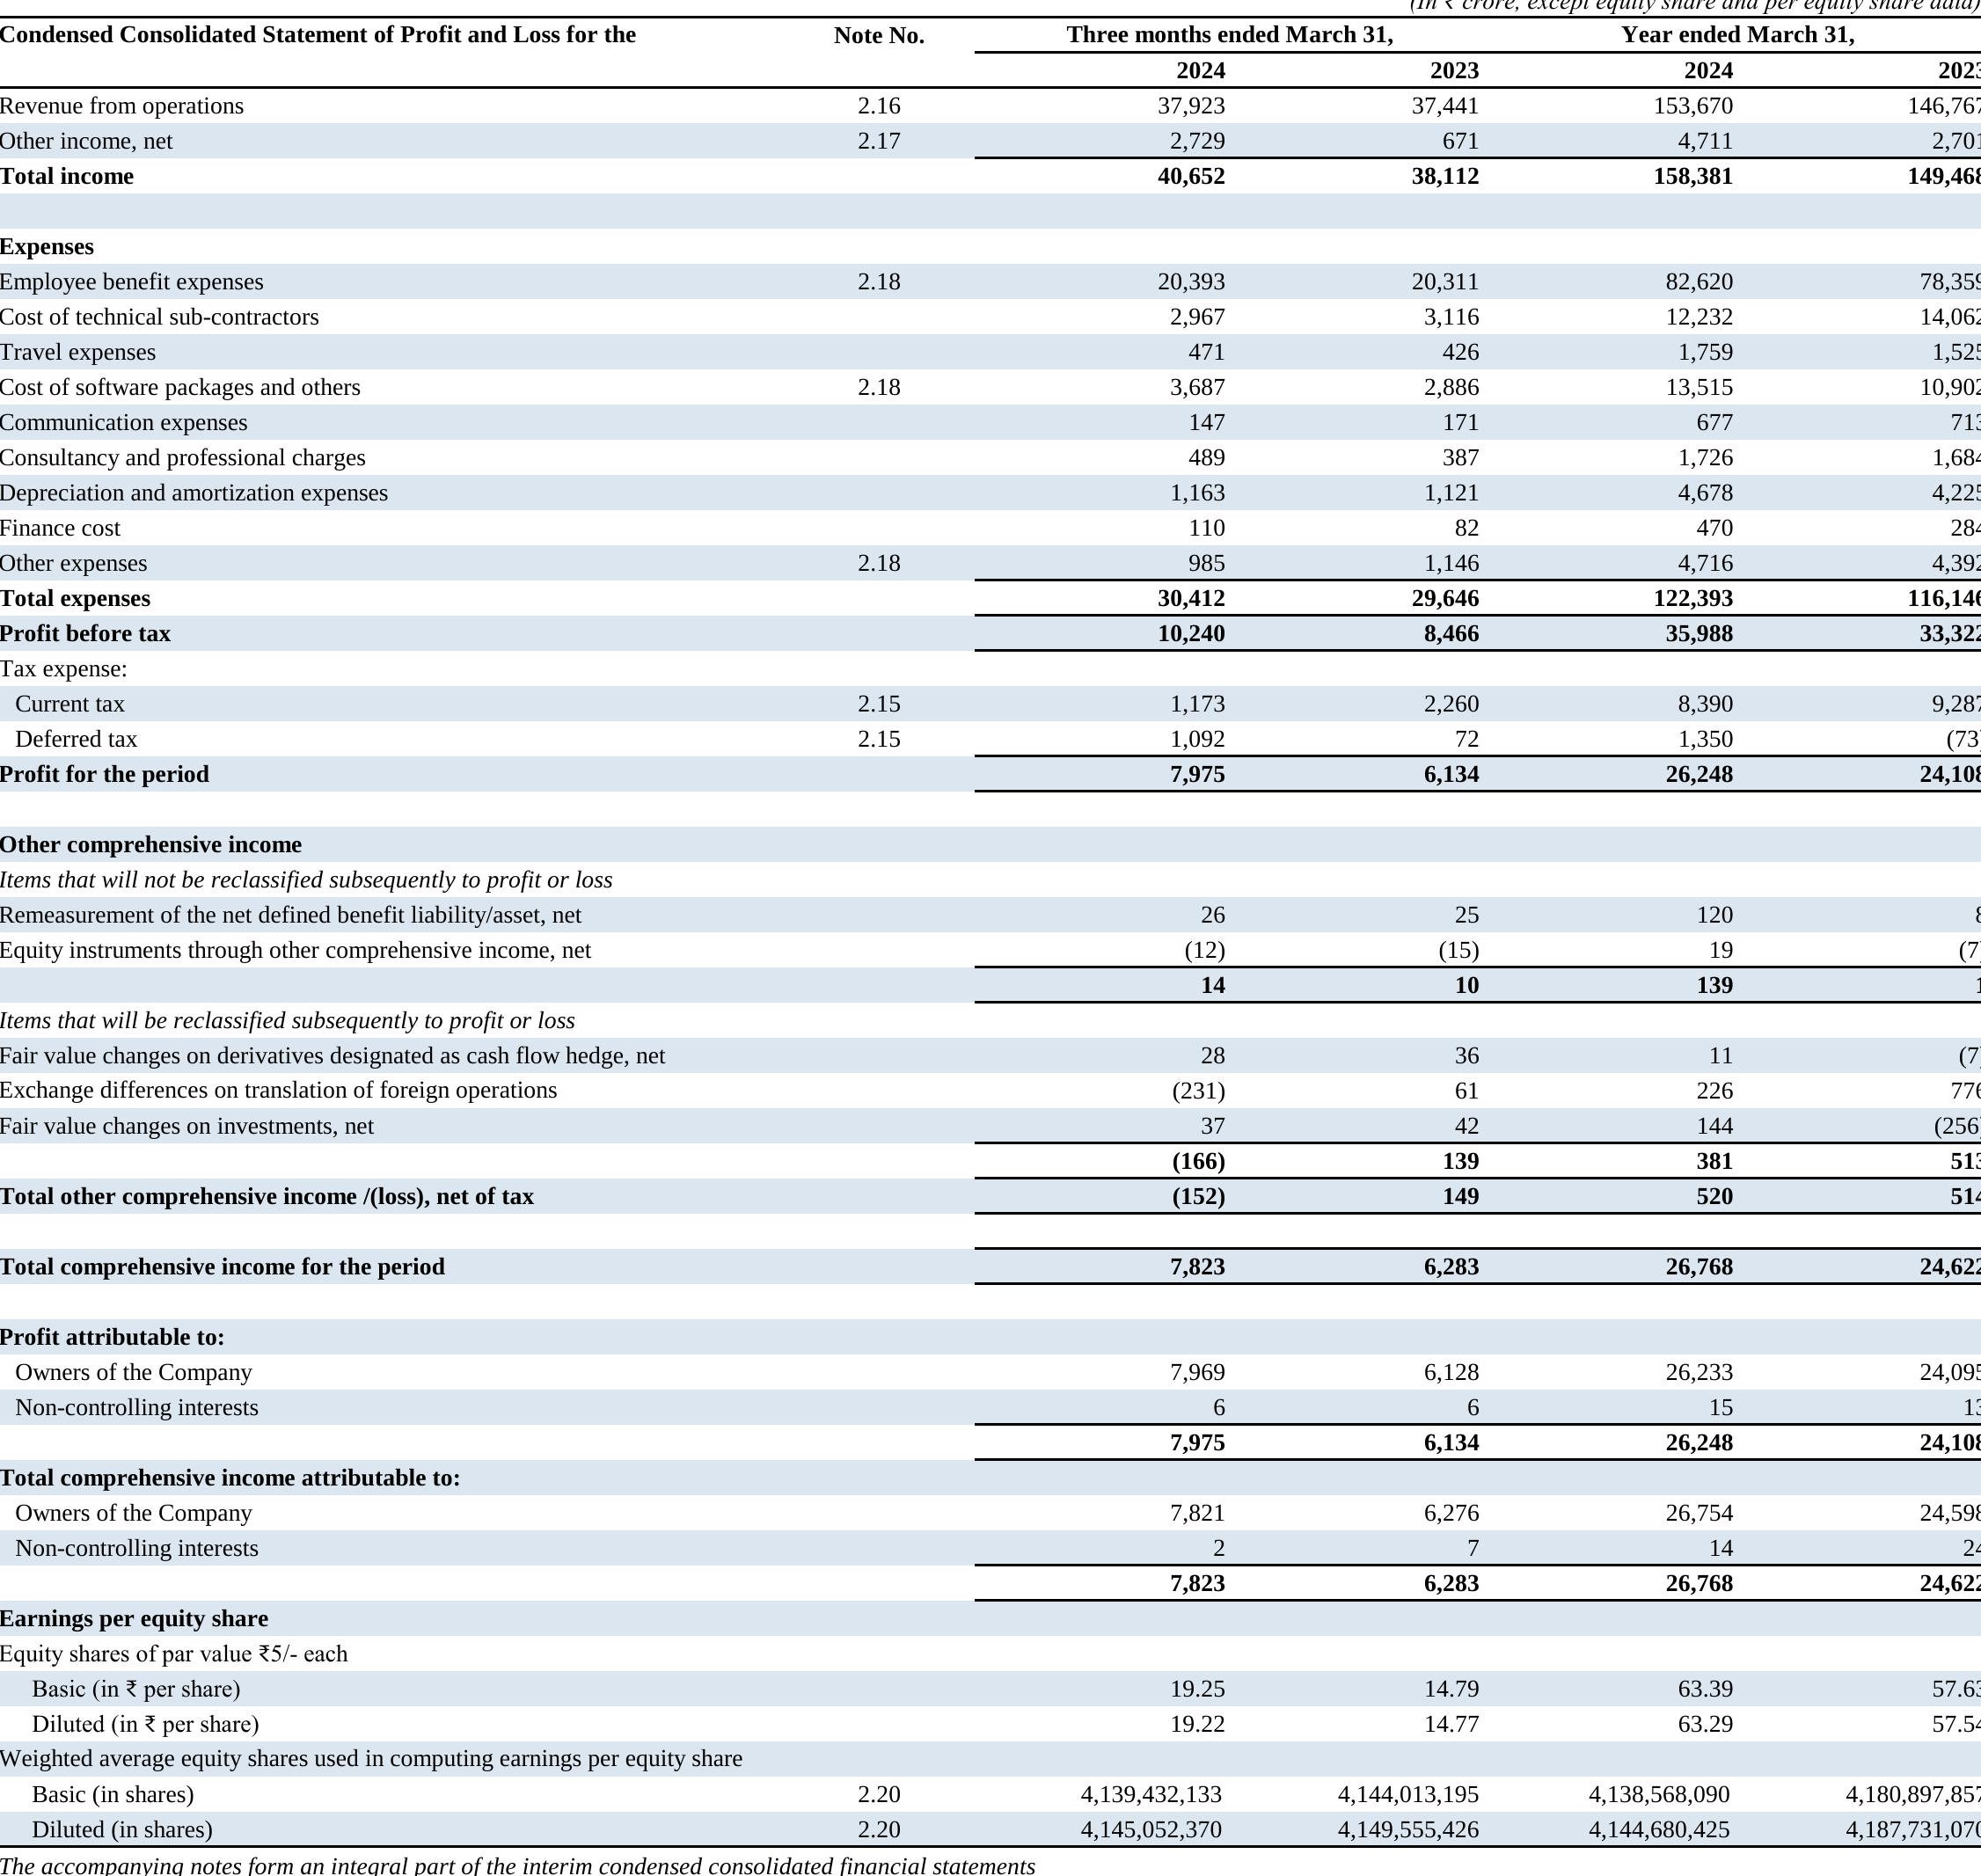

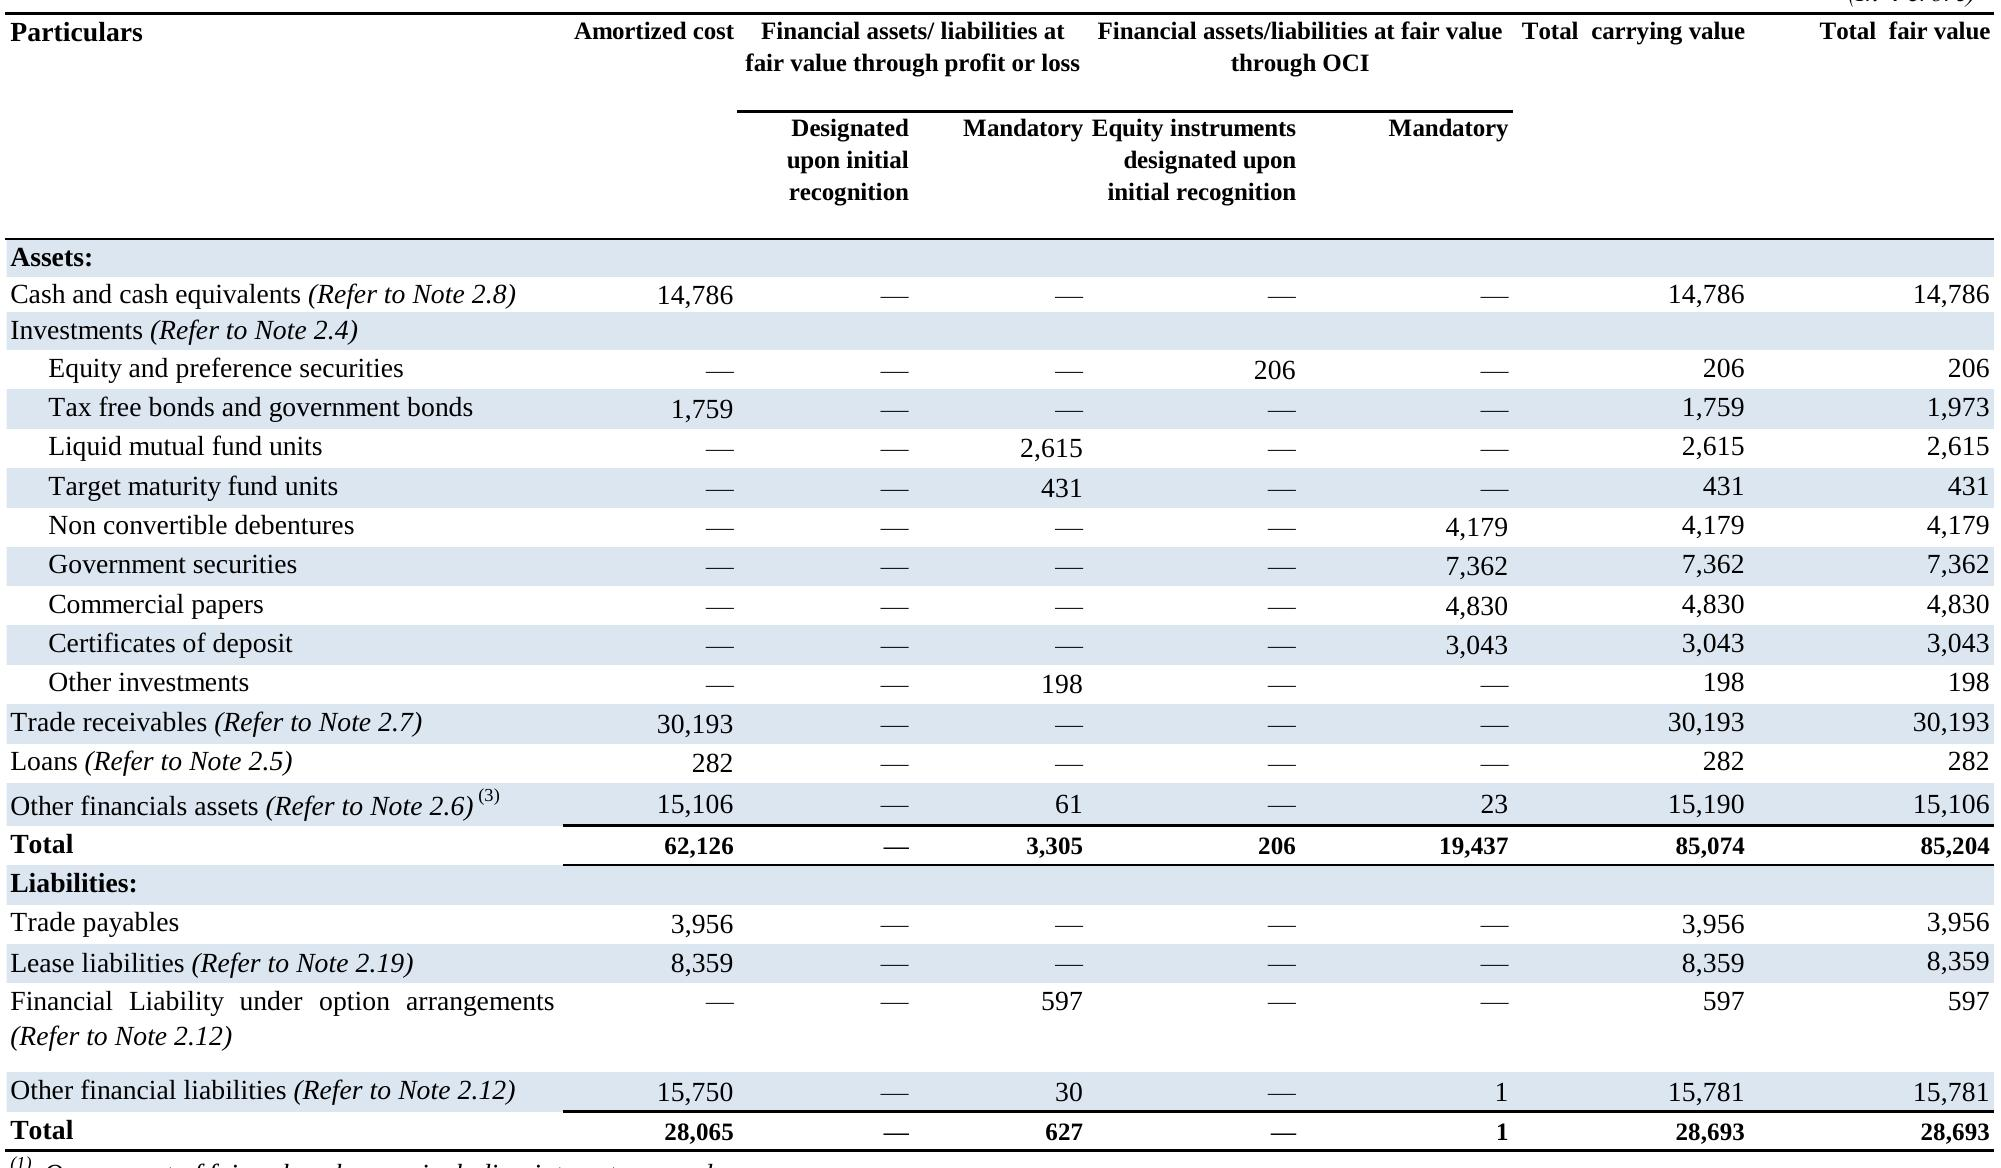

In [ ]:


import os
from PIL import Image

def get_image_paths(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

def find_table_images(table_indices, img_folder="extracted_data"):
    image_paths = get_image_paths(img_folder)
    return [image_paths[i] for i in table_indices if i < len(image_paths)]

def display_matched_tables(query, tables, img_folder="extracted_data"):
    table_embedder = TableEmbedder()
    relevant_tables = table_embedder.retrieve_top_k_tables(query, tables)

    # Get indices of matched tables
    table_indices = [tables.index(table) for table in relevant_tables]

    # Get corresponding image paths
    matched_images = find_table_images(table_indices)

    # Display images
    for img_path in matched_images:
        img = Image.open(img_path)
        display(img)

# Usage
result = table_query_processor("What is the gross profit for Q3 2024?", tab)
display_matched_tables("What is the gross profit for Q3 2024?", tab)

In [ ]:
print(result['answer'])

The gross profit for the three months ended March 31, 2024 (Q3 2024) is ₹11,175 crore.



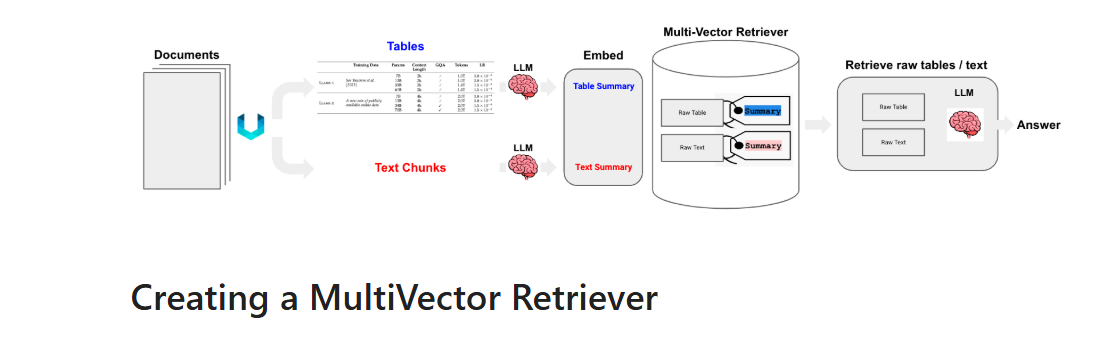

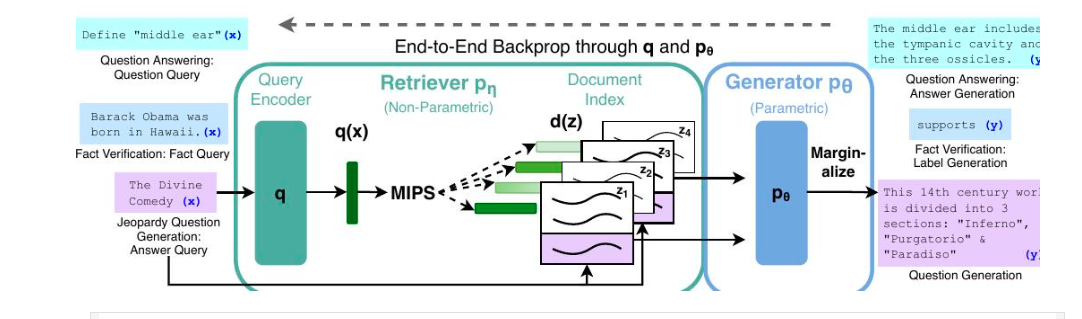